# Animal detection

### Introduction

### Imports and settings

In [1]:
# Standard Python libraries:
import operator
import os
import sys
import time
from typing import List, Tuple, Dict, Any, Union, Optional
import warnings

# Data processing and modeling:
from keras.layers import Dense, Conv2D, Flatten
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
import numpy as np

# Data visualization:
from IPython import display
# import matplotlib.pyplot as plt
# from PIL import Image

# Settings:
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

### Data exploration

To get a feel for the data we are working with, let us inspect two random images: one from the training set and one from the test set:

Random train image:

Format:	 JPEG
Mode:	 RGB
Size:	 (1024, 815)


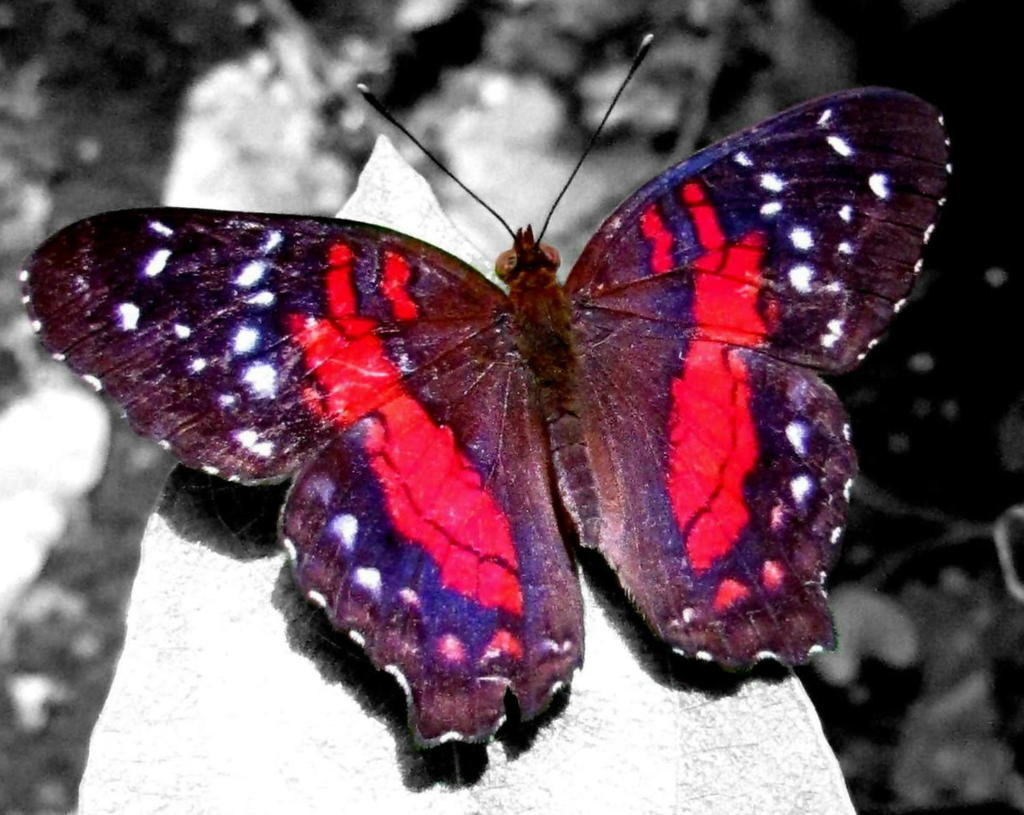

In [2]:
data_path = "data/"
example_path = data_path + "train/Butterfly/0ac0ebf6b74941a5.jpg"
example_img = load_img(example_path)
print("Random train image:\n")
print("Format:\t", example_img.format)
print("Mode:\t", example_img.mode)
print("Size:\t", example_img.size)
display.Image(example_path)

Random test image:

Format:	 JPEG
Mode:	 RGB
Size:	 (1024, 768)


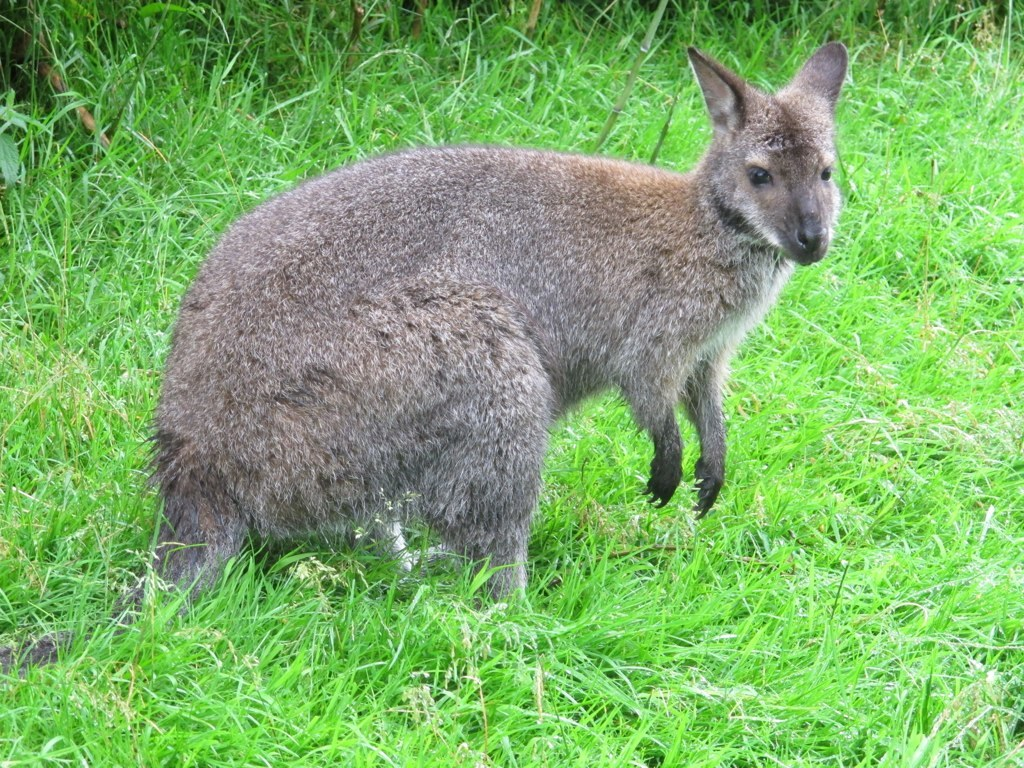

In [3]:
example_path = data_path + "test/Kangaroo/1df62fe536aae753.jpg"
example_img = load_img(example_path)
print("Random test image:\n")
print("Format:\t", example_img.format)
print("Mode:\t", example_img.mode)
print("Size:\t", example_img.size)
display.Image(example_path)

Both images have three color channels and they have almost the same resolution. For our CNN we need a fixed resolution, which might lead to rescaling or dropping of certain images. In the following we will inspect all image modes and resolutions to map the characteristics of our datasets. To this end, we will define a function that can obtain the full paths of all images in a given folder:

In [4]:
def get_files(
    dir_path: str, 
    extensions: Tuple[str] = (".jpg", ".jpeg", ".png"),
) -> List[str]:
    """Obtain all files in the directory tree of the given folder.

    Args:
        dir_path: The path to the directory.
        extensions: Optional argument that can be used to specify 
            desired extensions. By default only images are listed.

    Returns:
        List of full paths to all files that are contained in
        the input directory, including subdirectories.
    """

    list_of_items = os.listdir(dir_path)
    all_files = []
    for item in list_of_items:
        full_path = os.path.join(dir_path, item).strip()
        if os.path.isdir(full_path):
            all_files = all_files + get_files(full_path)
        else:
            if full_path.endswith(extensions):
                all_files.append(full_path)

    return all_files

In [5]:
img_paths = get_files(data_path)
data_info = {"Formats": {}, "Modes": {}, "Sizes": {}}
failed_imgs = []
successes = 0

# Determine characterics for each image:
for img_path in img_paths:
    try:
        img = load_img(img_path)      
        ext = img.format
        if ext not in data_info["Formats"]:
            data_info["Formats"][ext] = 1
        else:
            data_info["Formats"][ext] += 1
            
        mode = img.mode
        if mode not in data_info["Modes"]:
            data_info["Modes"][mode] = 1
        else:
            data_info["Modes"][mode] += 1
            
        size = img.size
        if size not in data_info["Sizes"]:
            data_info["Sizes"][size] = 1
        else:
            data_info["Sizes"][size] += 1
            
        successes += 1
    except:
        failed_imgs.append(img_path)

# Sort dictionaries by values:
data_info["Formats"] = sorted(data_info["Formats"].items(), key=operator.itemgetter(1), reverse=True)
data_info["Modes"] = sorted(data_info["Modes"].items(), key=operator.itemgetter(1), reverse=True)
data_info["Sizes"] = sorted(data_info["Sizes"].items(), key=operator.itemgetter(1), reverse=True)

print(f"There are {len(failed_imgs)} corrupt images in the dataset. Based on the remaining {successes} images, the dataset characteristics are as follows:")
print("\nFormats:\t", data_info["Formats"])
print("\nModes:\t\t", data_info["Modes"])
print("\nSizes:\t\t", data_info["Sizes"])

There are 0 corrupt images in the dataset. Based on the remaining 25532 images, the dataset characteristics are as follows:

Formats:	 [('JPEG', 25214), (None, 304), ('MPO', 14)]

Modes:		 [('RGB', 25532)]

Sizes:		 [((1024, 768), 5868), ((1024, 683), 4378), ((1024, 680), 807), ((1024, 682), 805), ((1024, 1024), 788), ((1024, 681), 770), ((768, 1024), 693), ((683, 1024), 633), ((1024, 685), 597), ((1024, 576), 403), ((1024, 678), 305), ((1024, 687), 224), ((1024, 684), 202), ((1024, 819), 189), ((1024, 731), 146), ((1024, 686), 130), ((682, 1024), 130), ((1024, 769), 129), ((681, 1024), 116), ((685, 1024), 106), ((1024, 679), 105), ((680, 1024), 94), ((1024, 577), 92), ((1024, 766), 92), ((1024, 640), 81), ((1024, 575), 77), ((1024, 767), 77), ((1024, 732), 76), ((768, 768), 75), ((1024, 765), 48), ((1024, 770), 46), ((819, 1024), 46), ((678, 1024), 43), ((1024, 677), 40), ((1024, 724), 36), ((1024, 691), 35), ((1024, 676), 34), ((1024, 737), 30), ((1024, 771), 30), ((1024, 791), 30), 

All images in the dataset are of the RGB type. The sizes, however, vary considerably. The most common number of pixels for the long edge is 1024.

### Preprocessing

Before we can train a model, we ne

### Model building

In this section we can build and train a CNN using Keras.

In [8]:
model = Sequential()
model.add(Conv2D(64, (5, 5), padding="same", activation="relu", input_shape=(28, 28, 3)))
model.add(Conv2D(32, (5, 5), padding="same", activation="relu"))
model.add(Conv2D(16, (5, 5), padding="same", activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        51232     
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
Total params: 306,986
Trainable params: 306,986
Non-trainable params: 0
_________________________________________________________________


Now we can compile and train the model:

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

NameError: name 'X_train' is not defined

#### To do:

- Add pretrained weights.
- What to do with vertical images?
- Add data augmentation.
- Maybe apply data standardization.
- Apply regularization (at least drop-out).